# Stochastic time-series forecast with ARMA or ARIMA
# Overview
The goal is to find the `stationarity` of the target process (i.e., minimum
temperature here) to employ the time-series forecast model AutoRegressive
Integrated Moving Average (ARIMA).

# Theory
Non-stationarity is defined when [unit root](https://en.wikipedia.org/wiki/Unit_root) of the characteristic equation
of the autoregressive model exists, or the less common case when [root is larger than 1](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1468-2354.2010.00625.x).
For now the focused is on unit root test for stationarity.

# Data
[Download](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line)
the minimun daily temperature of Melbourne, Australia from 1981 to 1990. Two
years are missing data on 12/31, and are filled in by linear interpolation.
Three days of data value with question marks are removed.

Read the data, rename the variable, add time index, and cast the data type to numeric:

In [1]:
import pandas as pd
series = pd.read_csv('~/Downloads/daily-minimum-temperatures-in-me.csv', error_bad_lines=False)
series.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990':'mint'},inplace=True) # rename minimum temp to 'mint'
y = pd.to_numeric(series["mint"],downcast='float')
y.index = pd.DatetimeIndex(start='1981-01-01',end='1990-12-31',freq='d')
print(y)

1981-01-01    20.700001
1981-01-02    17.900000
1981-01-03    18.799999
1981-01-04    14.600000
1981-01-05    15.800000
1981-01-06    15.800000
1981-01-07    15.800000
1981-01-08    17.400000
1981-01-09    21.799999
1981-01-10    20.000000
1981-01-11    16.200001
1981-01-12    13.300000
1981-01-13    16.700001
1981-01-14    21.500000
1981-01-15    25.000000
1981-01-16    20.700001
1981-01-17    20.600000
1981-01-18    24.799999
1981-01-19    17.700001
1981-01-20    15.500000
1981-01-21    18.200001
1981-01-22    12.100000
1981-01-23    14.400000
1981-01-24    16.000000
1981-01-25    16.500000
1981-01-26    18.700001
1981-01-27    19.400000
1981-01-28    17.200001
1981-01-29    15.500000
1981-01-30    15.100000
                ...    
1990-12-02    13.200000
1990-12-03    16.200001
1990-12-04    17.299999
1990-12-05    20.500000
1990-12-06    20.200001
1990-12-07    19.400000
1990-12-08    15.500000
1990-12-09    14.100000
1990-12-10    11.000000
1990-12-11    11.100000
1990-12-12    14

Check out the data lag correlation to determine how much lag is appropriate:

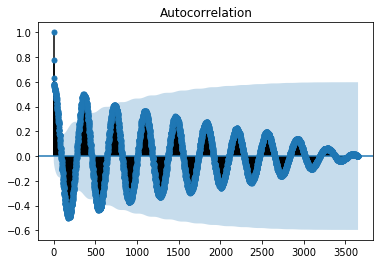

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
plot_acf(y)
pyplot.show()

Notice there are periodic oscillations due to the seasonal cycle.

Decompose the data into trend, season, and residual (first guess of stationary process):

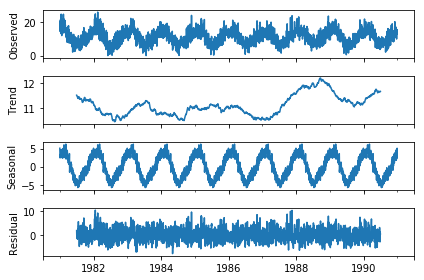

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y, model='additive',freq=365) # 365 is the sampling freq (N/T) in a period T=year
decomposition.plot()
pyplot.show()

Notice the warming trend, seasonal cycle and randomness of day-to-day residuals.

The residual might be the stationary time-series needed, let's look at the autocorrelation:

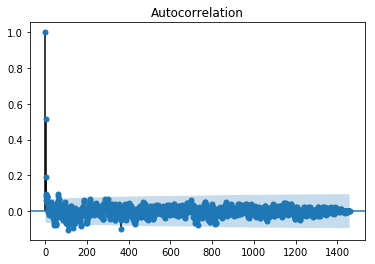

In [6]:
plot_acf(decomposition.resid[365:365*5])
pyplot.show()

Use the residual time series and split it into test and validation sets:

In [7]:
y = decomposition.resid
y.index = pd.DatetimeIndex(start='1981-01-01',end='1990-12-31',freq='d')
test, valid = y[365:365*4], y[365*4:365*10],
test.index, valid.index = y.index[365:365*4], y.index[365*4:365*10]


# Build Model
Set up the model hyperparameters
  * (p,d,q): order of the AR parameters, differences, and MA parameters.
  * (P,D,Q,s): order of the AR parameters, differences, and MA parameters for seasonal component.

In [9]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) # (p,d,q)
#seasonal_pdq = [(x[0], x[1], x[2], 365) for x in pdq] # (P,D,Q,s), sampling freq = 365
seasonal_pdq = [(0, 0, 0, 0)] # just disregard the seasons for now

[Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion)
is used to select the best model from grid search:

In [10]:
import warnings
from statsmodels.tsa.arima_model import ARIMA # ARIMA model
from statsmodels.tsa.stattools import adfuller # augmented Dickey-Fuller test
from statsmodels.tsa.statespace.sarimax import SARIMAX # seasonal ARIMA

warnings.filterwarnings("ignore")
aic_min = float("inf")
param = (0,0,0,0,0,0) # (p,d,q,P,D,Q,s)
best_model = None # low AIC is better

for x1 in pdq:
    for x2 in seasonal_pdq:
        try:
            mod = SARIMAX(test, order = x1, seasonal_order = x2, enforce_stationarity = False, enforce_invertibility = False)
            results = mod.fit() # this stage is slow
            print("(p,d,q,P,D,Q,s) = {}: AIC = {}".format(x1 + x2, results.aic))
            if results.aic < aic_min:
                aic_min = results.aic
                param = x1 + x2
                best_model = mod
        except:
            continue

(p,d,q,P,D,Q,s) = (0, 0, 0, 0, 0, 0, 0): AIC = 5284.785300207412
(p,d,q,P,D,Q,s) = (0, 0, 1, 0, 0, 0, 0): AIC = 4973.068454202497
(p,d,q,P,D,Q,s) = (0, 1, 0, 0, 0, 0, 0): AIC = 5268.505449625764
(p,d,q,P,D,Q,s) = (0, 1, 1, 0, 0, 0, 0): AIC = 5181.376314494853
(p,d,q,P,D,Q,s) = (1, 0, 0, 0, 0, 0, 0): AIC = 4963.805581999457
(p,d,q,P,D,Q,s) = (1, 0, 1, 0, 0, 0, 0): AIC = 4945.325590958033
(p,d,q,P,D,Q,s) = (1, 1, 0, 0, 0, 0, 0): AIC = 5241.869185637312
(p,d,q,P,D,Q,s) = (1, 1, 1, 0, 0, 0, 0): AIC = 4964.828337406234


Show the best model hyperparameter

In [11]:
print("Best (p,d,q,P,D,Q,s) =", param)

Best (p,d,q,P,D,Q,s) = (1, 0, 1, 0, 0, 0, 0)


Show the statistics of the best model:

In [12]:
results = best_model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3223      0.052      6.201      0.000       0.220       0.424
ma.L1          0.2491      0.054      4.590      0.000       0.143       0.355
sigma2         5.3715      0.227     23.632      0.000       4.926       5.817


Show the residual between true and prediction:

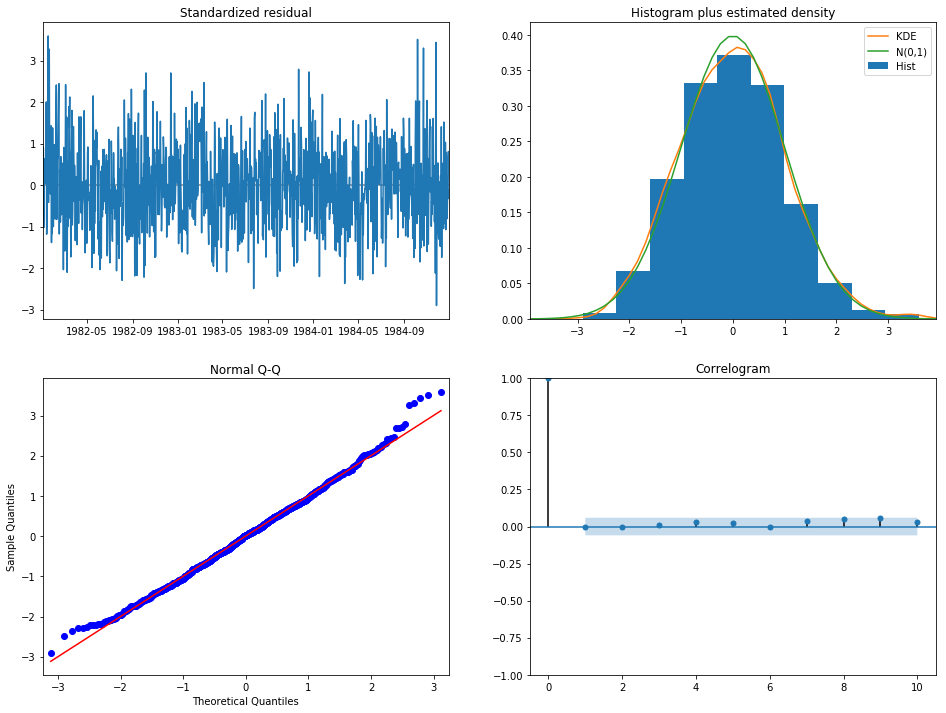

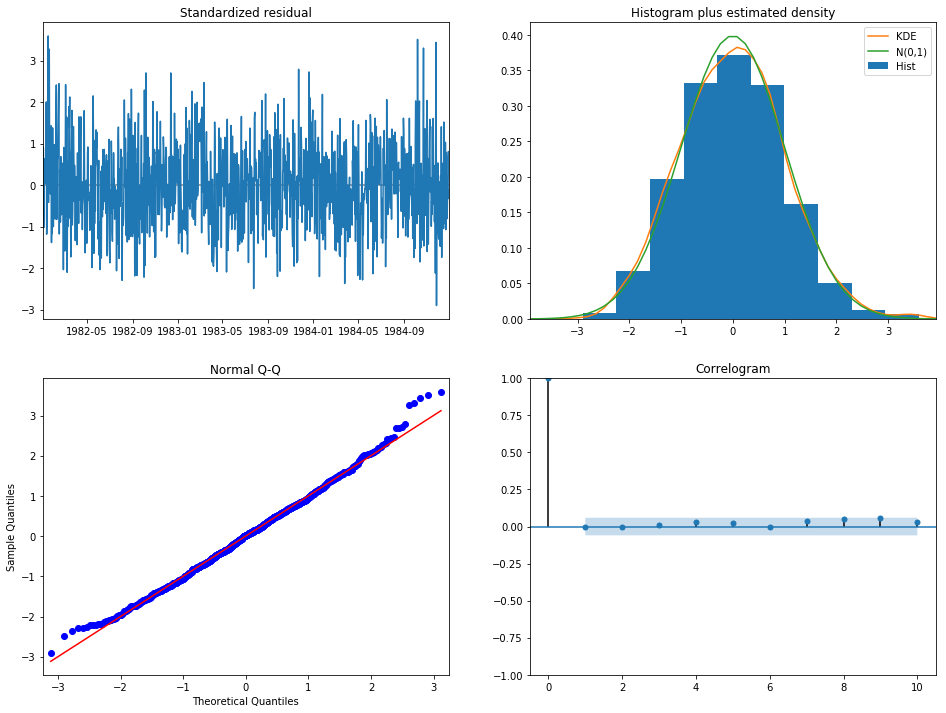

In [17]:
results.plot_diagnostics(figsize=(16, 12))

# References
* [seasonal ARIMA (SARIMAX)](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)
* [SARIMAX.fit() theory](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.fit.html#statsmodels.tsa.statespace.sarimax.SARIMAX.fit)
* [seasonal_decomposition](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)
* [augmented Dickey-Fuller theory](http://support.sas.com/documentation/cdl/en/etsug/63939/HTML/default/viewer.htm#etsug_macros_sect007.htm)
* [minimum temperature data](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line)
* [reference project (SF crime)](https://github.com/liyenhsu/SF-Crime-Analysis/blob/master/sf_crime_analysis.ipynb?fbclid=IwAR1sqdDd2izosGw6axuYoGei3288ab-lBgvS6LfDyaeJ8IWzFkNmGtm1cZ4)
* [reference project (min T)](https://machinelearningmastery.com/make-sample-forecasts-arima-python/)
* [unit root](https://en.wikipedia.org/wiki/Unit_root)
* [explosive process](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1468-2354.2010.00625.x)
* [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion)